# Importing libraries and loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib


df = pd.read_csv('https://raw.githubusercontent.com/codebasics/py/master/DataScience/BangloreHomePrices/model/bengaluru_house_prices.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


# Preprocessing

In [2]:
# Dimensionality of the dataset
df.shape

(13320, 9)

In [3]:
# Check the different types of areas 
df.area_type.unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [4]:
df['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

## Handling missing values

In [5]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [6]:
# Since 'society' column has hude number of missing values, we drop the column
df.drop(['society'], axis=1, inplace=True)
df.head(3)

,area_type,availability,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,62.00


In [7]:
df.shape

(13320, 8)

In [8]:
# Drop all rows with null values
df2 = df.dropna()
df2.shape

(12710, 8)

In [9]:
df2.isnull().sum()

area_type       0
availability    0
location        0
size            0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64

## Feature Engineering

In [10]:
df2['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '3 Bedroom', '1 BHK', '1 RK',
       '4 BHK', '1 Bedroom', '2 Bedroom', '6 Bedroom', '8 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '11 Bedroom', '43 Bedroom',
       '14 BHK', '8 BHK', '12 Bedroom', '10 Bedroom', '13 BHK'],
      dtype=object)

An ML model typically works well with only numeric values. Therefore, here, we need to extract the bedroom count value from the 'size' column.

In [11]:
df2['bhk'] = df2['size'].apply(lambda x: int(x.split(' ')[0]))
df2.bhk.unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([ 2,  4,  3,  1,  6,  8,  7,  5, 11,  9, 27, 43, 14, 12, 10, 13])

We see that there are houses with 23 and 43 bedroos which seems odd. Lets look in detail

In [12]:
df2[df2.bhk > 20]

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk
1718,Super built-up Area,Ready To Move,2Electronic City Phase II,27 BHK,8000,27.0,0.0,230.0,27
4684,Plot Area,Ready To Move,Munnekollal,43 Bedroom,2400,40.0,0.0,660.0,43


A 43 bhk in 2400sqft and 27bhk in 8000sqft doesnt look feasible. So, these 2 rows might be errors. So we remove these rows.



---
Lets explore total_sqft column.


In [13]:
df2.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

There seems to be some inconsistancies in the data like '1133 - 1384', which is a range rather than a particular numeric value. Lets check, if there are any more such inconsistancies.

In [14]:
# We create a function for finding inconsistancies in total_sqft
def sqft_value(x):
  try:
    float(x)
  except:
    return False
  return True

# The above function will return rows with a single numeric value in total_sqft

In [15]:
# But we need values that are inconsistant, so,
df2[~df2.total_sqft.apply(sqft_value)].head(10)

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk
30,Super built-up Area,19-Dec,Yelahanka,4 BHK,2100 - 2850,4.0,0.0,186.000,4
122,Super built-up Area,18-Mar,Hebbal,4 BHK,3067 - 8156,4.0,0.0,477.000,4
137,Super built-up Area,19-Mar,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,0.0,54.005,2
165,Super built-up Area,18-Dec,Sarjapur,2 BHK,1145 - 1340,2.0,0.0,43.490,2
188,Super built-up Area,Ready To Move,KR Puram,2 BHK,1015 - 1540,2.0,0.0,56.800,2
410,Super built-up Area,Ready To Move,Kengeri,1 BHK,34.46Sq. Meter,1.0,0.0,18.500,1
549,Super built-up Area,18-Sep,Hennur Road,2 BHK,1195 - 1440,2.0,0.0,63.770,2
661,Super built-up Area,Ready To Move,Yelahanka,2 BHK,1120 - 1145,2.0,0.0,48.130,2
672,Built-up Area,18-Mar,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,0.0,445.000,4
772,Super built-up Area,20-Dec,Banashankari Stage VI,2 BHK,1160 - 1195,2.0,0.0,59.935,2


Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [16]:
# Define a function to perform the above mentioned job.
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
      return None

In [17]:
df3 = df2.copy()
df3.total_sqft = df3.total_sqft.apply(convert_sqft_to_num)
df3.head(10)

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2
5,Super built-up Area,Ready To Move,Whitefield,2 BHK,1170.0,2.0,1.0,38.00,2
8,Super built-up Area,Ready To Move,Marathahalli,3 BHK,1310.0,3.0,1.0,63.25,3
10,Super built-up Area,18-Feb,Whitefield,3 BHK,1800.0,2.0,2.0,70.00,3
11,Plot Area,Ready To Move,Whitefield,4 Bedroom,2785.0,5.0,3.0,295.00,4
12,Super built-up Area,Ready To Move,7th Phase JP Nagar,2 BHK,1000.0,2.0,1.0,38.00,2


In [18]:
df3.total_sqft.isnull().sum()

42

In [19]:
df3 = df3[df3.total_sqft.notnull()]
df3.total_sqft.isnull().sum()

0

For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850

In [20]:
df3.loc[30]

area_type       Super built-up  Area
availability                  19-Dec
location                   Yelahanka
size                           4 BHK
total_sqft                      2475
bath                               4
balcony                            0
price                            186
bhk                                4
Name: 30, dtype: object

## Feature engineering

In [21]:
# Add new feature called price per square feet

df4 = df3.copy()
df4['price_per_sqft'] = (df4['price']*100000) / df4['total_sqft']
df4.head(3)

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4,4615.384615
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3,4305.555556


Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [22]:
df4.location = df4.location.apply(lambda x: x.strip())
location_stats = df4['location'].value_counts(ascending=False)
location_stats

Whitefield                   514
Sarjapur  Road               372
Electronic City              302
Kanakpura Road               259
Thanisandra                  233
                            ... 
Gulakamale                     1
Huttanahalli                   1
Bilal Nagar                    1
TR Mill Road, Chamarajpet      1
Ramamohanapuram                1
Name: location, Length: 1248, dtype: int64

In [23]:
location_stats.values.sum()

12668

In [24]:
# Locations with more than 10 rows
len(location_stats[location_stats>10])

235

In [25]:
# Total number of locations
len(location_stats)

1248

In [26]:
# Locations with less than 10 rows
len(location_stats[location_stats<=10])

1013

**Dimensionality Reduction**

Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [27]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Thyagaraja Nagar             10
Naganathapura                10
HAL 2nd Stage                10
Basapura                     10
Doddaballapur                10
                             ..
Gulakamale                    1
Huttanahalli                  1
Bilal Nagar                   1
TR Mill Road, Chamarajpet     1
Ramamohanapuram               1
Name: location, Length: 1013, dtype: int64

In [28]:
len(df4.location.unique())

1248

In [29]:
df4.location = df4.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df4.location.unique())

236

In [30]:
df4.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4,4615.384615
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3,4305.555556
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3,6245.890861
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2,4250.000000


## Outlier Removal Using Business Logic

As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [31]:
df4[df4.total_sqft/df4.bhk<300].head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
58,Plot Area,Ready To Move,Murugeshpalya,6 Bedroom,1407.0,4.0,1.0,150.0,6,10660.980810
68,Plot Area,Ready To Move,Devarachikkanahalli,8 Bedroom,1350.0,7.0,0.0,85.0,8,6296.296296
70,Plot Area,Ready To Move,other,3 Bedroom,500.0,3.0,2.0,100.0,3,20000.000000
78,Built-up Area,Ready To Move,Kaval Byrasandra,2 BHK,460.0,1.0,0.0,22.0,2,4782.608696
89,Plot Area,Ready To Move,Rajaji Nagar,6 Bedroom,710.0,6.0,3.0,160.0,6,22535.211268


In [32]:
df4.shape

(12668, 10)

In [33]:
df5 = df4[~(df4.total_sqft/df4.bhk<300)]
df5.shape

(12013, 10)

**Outlier Removal Using Standard Deviation and Mean**

In [34]:
df5.price_per_sqft.describe()

count     12013.000000
mean       6206.082347
std        3985.518807
min         267.829813
25%        4199.363057
50%        5252.525253
75%        6823.529412
max      176470.588235
Name: price_per_sqft, dtype: float64

Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [35]:
# function for removing outliers
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out


df6 = remove_pps_outliers(df5)
df6.shape

(9852, 10)

Let's check for a given location how does the 2 BHK and 3 BHK property prices look like

In [36]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    

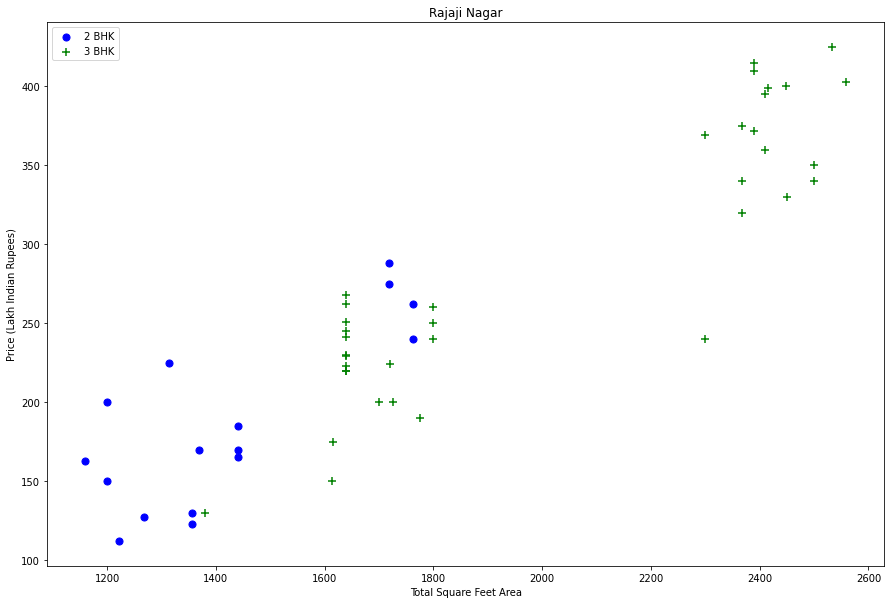

In [37]:
# for Rajai nagar
plot_scatter_chart(df6,"Rajaji Nagar")

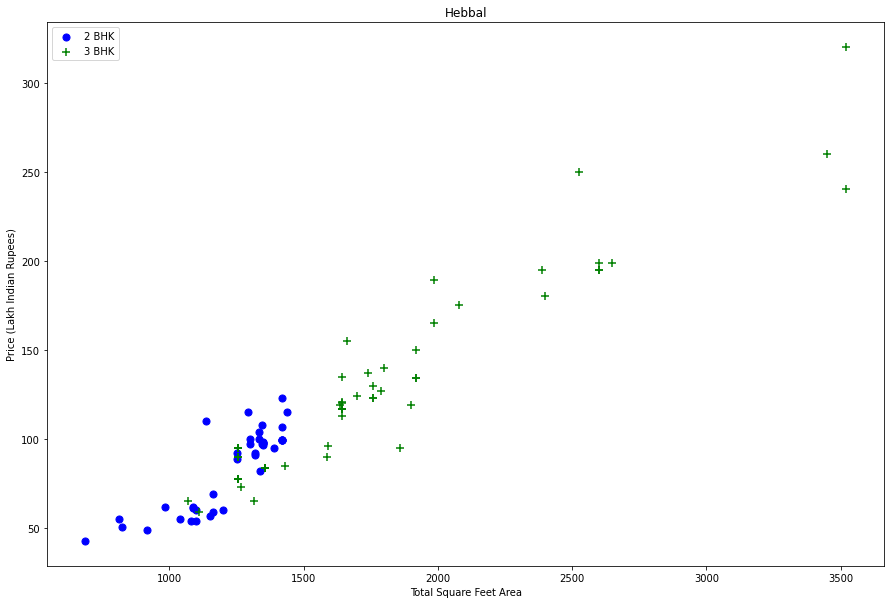

In [38]:
# for hebbal
plot_scatter_chart(df6,"Hebbal")

We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.


{

    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },

    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },  
}

Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [39]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

In [40]:
df7 = remove_bhk_outliers(df6)
df7.shape

(7014, 10)

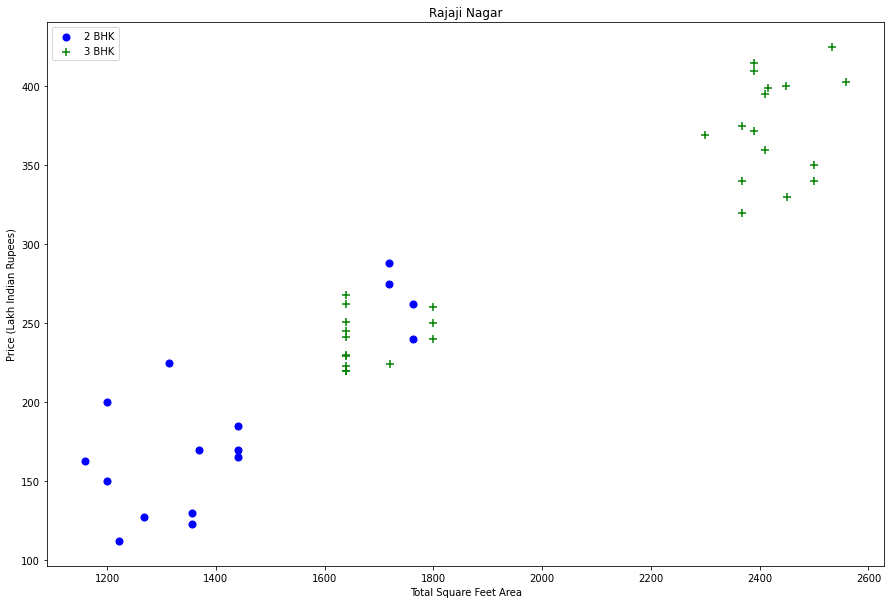

In [41]:
# Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties
plot_scatter_chart(df7,"Rajaji Nagar")

We can see that we have removed a lot of outliers

Text(0, 0.5, 'Count')

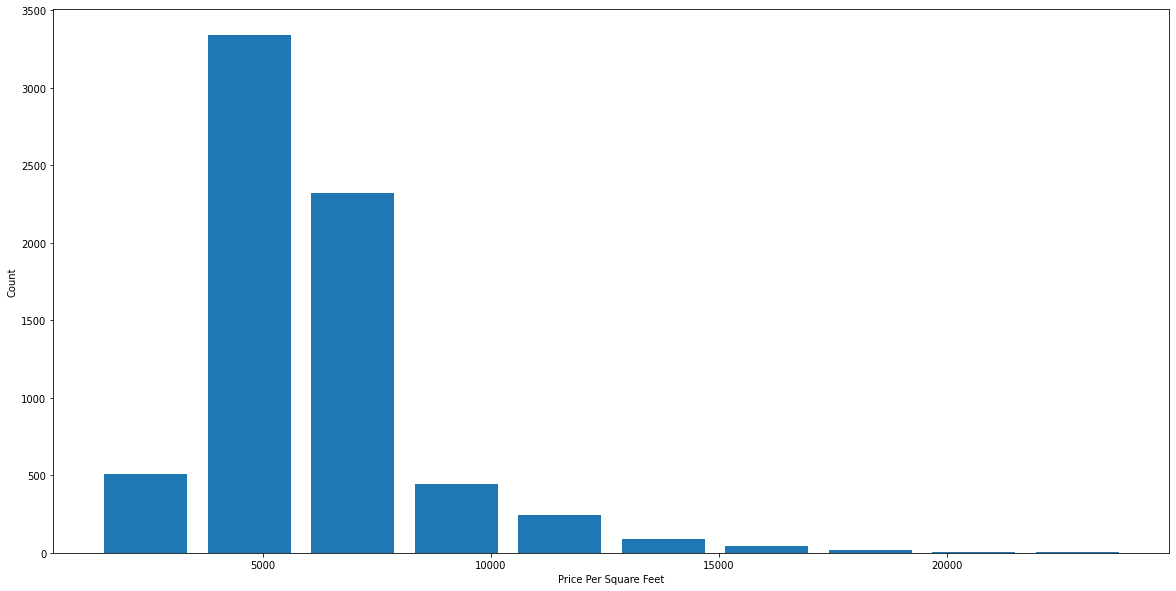

In [42]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df7.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

**Outlier Removal Using Bathrooms Feature**

In [43]:
df7.bath.unique()

array([ 4.,  3.,  2.,  8.,  1.,  5.,  6.,  7.,  9., 13.])

Text(0, 0.5, 'Count')

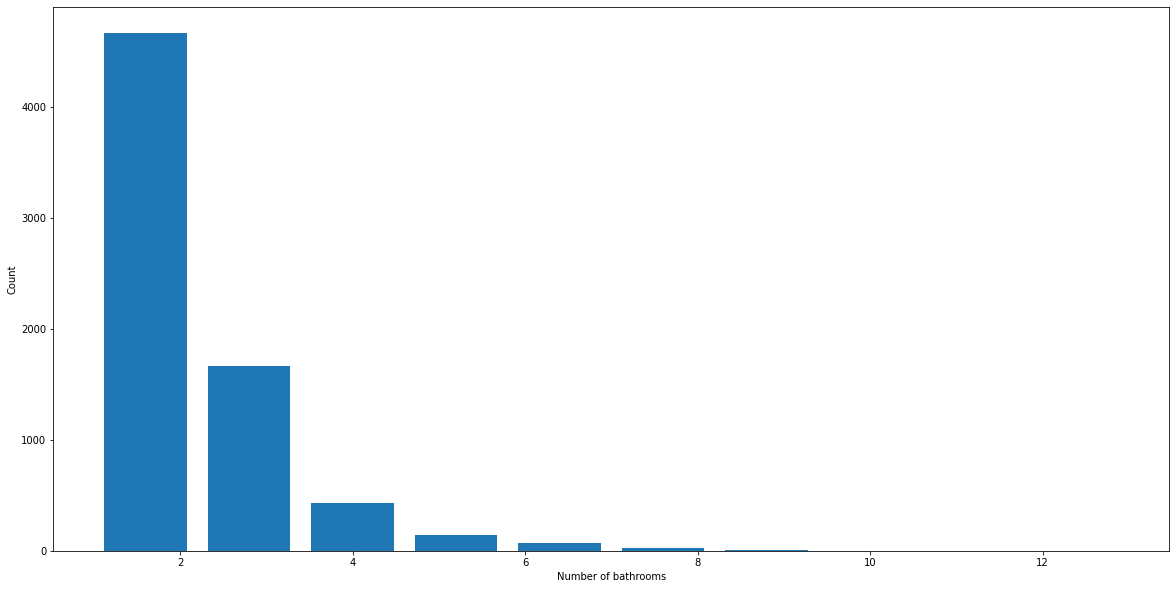

In [44]:
plt.hist(df7.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [45]:
# Some houses have 13 bathrooms.Lets look more into it
df7[df7.bath>10]

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
9267,Super built-up Area,Ready To Move,other,13 BHK,5425.0,13.0,0.0,275.0,13,5069.124424


Looks fine to have 13 bathrooms for 13bhk house. But if you have, say, 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed. So we need to consider that too while doing outlier detection.

In [46]:
df7[df7.bath>df7.bhk+2]

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
1542,Built-up Area,Ready To Move,Chikkabanavar,4 Bedroom,2460.0,7.0,2.0,80.0,4,3252.032520
6443,Super built-up Area,Ready To Move,Thanisandra,3 BHK,1806.0,6.0,2.0,116.0,3,6423.034330
8082,Super built-up Area,Ready To Move,other,6 BHK,11338.0,9.0,1.0,1000.0,6,8819.897689


In [47]:
df7.shape

(7014, 10)

In [48]:
df8 = df7[df7.bath<df7.bhk+2]
df8.shape

(6947, 10)

In [49]:
df9 = df8.drop(['area_type', 'availability', 'balcony', 'size','price_per_sqft'],axis='columns')
df9.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


# Use One Hot Encoding For Location

We can see that the columns location contains text data. When we are building the models, it is difficult for the models to process text data and is confortable with numeric data. Therefore we use the method of encoding, specifically oone hot encoding to convert the text data to numeric data.

In [50]:
dummies = pd.get_dummies(df9.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,Bannerghatta Road,Basavangudi,Basaveshwara Nagar,Battarahalli,...,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
df10 = pd.concat([df9,dummies.drop('other',axis='columns')],axis='columns')
df10.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,...,Sahakara Nagar,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
df11 = df10.drop('location',axis='columns')
df11.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,...,Sahakara Nagar,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# MOdel Building


In [53]:
df11.shape

(6947, 239)

In [54]:
X = df11.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,Bannerghatta Road,...,Sahakara Nagar,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [55]:
X.shape

(6947, 238)

In [56]:
y = df11.price
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [57]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

**Find best model using GridSearchCV**

In [58]:
from sklearn.model_selection import GridSearchCV

# We are going to compare 3 regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

In [59]:
# function to define parameters for each model and finding best model
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
                                'model': LinearRegression(),
                                'params': {
                                            'normalize': [True, False]
                                          }
                              },
        'lasso': {
                  'model': Lasso(),
                  'params': {
                              'alpha': [1,2],
                              'selection': ['random', 'cyclic']
                            }
                 },
        'decision_tree': {
                          'model': DecisionTreeRegressor(),
                          'params': {
                                      'criterion' : ['mse','friedman_mse'],
                                      'splitter': ['best','random']
                                    }
                         }
           }
    # Use K Fold cross validation to measure accuracy of our LinearRegression model
    from sklearn.model_selection import ShuffleSplit
    from sklearn.model_selection import cross_val_score

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
                        'model': algo_name,
                        'best_score': gs.best_score_,
                        'best_params': gs.best_params_
                      })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)           

,model,best_score,best_params
0,linear_regression,0.845238,{'normalize': True}
1,lasso,0.683942,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.635501,"{'criterion': 'mse', 'splitter': 'random'}"


Based on above results we can say that LinearRegression gives the best score. Hence we will use that.

In [60]:
# Create object for the classifier
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
#lr_clf.score(X_test,y_test)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
# Predict test set
y_pred = lr_clf.predict(X_test)

# Check the accuracy of the model
lr_clf.score(X_test, y_test)


0.8587320103453129

We get an approximately 85% accuracy, which is great. We can improve the accuracy further, but for now, we stop here.

In [67]:
# Create a pickle file.
import pickle
pickle.dump(lr_clf, open('model.pkl', 'wb'))

We can also create a function which takes input variables and predicts price as output.

In [62]:
# Function to predict price when input (independent variables) are provided
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [63]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

91.64521372279435

In [64]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

91.3509413441243

In [65]:
predict_price('Indira Nagar',1000, 2, 2)

152.22103006370506